In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

from plotting_utils import *

In [7]:
ROOT = '../logs/seed_runs'


In [8]:
def get_seed_73_runs(run_folder, algorithm_name):
    task_pattern=r"^.*_([a-z]*-*[a-z]+-v2)_.*$"
    folders = [os.path.join(ROOT, run_folder, folder) for folder in os.listdir(os.path.join(ROOT, run_folder))]
    all_results = pd.DataFrame()
    for folder in folders:
        # print(folder)
        if 'train' in folder:
            # print('skipping due to train')
            continue

        # file_loc = os.path.join(folder, )
        seed = 73 # if 73 otherwise use regex extraction
        task_match = re.search(task_pattern, folder)
        # print(task_match.groups())

        result = (
            resultSet(folder, algorithm_name)
            .collect_results()
            .assign(
                seed = seed,
                training_task = task_match.groups()[0],
            )
        )
        all_results = pd.concat([all_results, result])

    return all_results

def get_other_seed_runs(run_folder, algorithm_name):
    task_and_seed_pattern=r"^.*_(?P<task>[a-z]*-*[a-z]+-v2)_(?P<seed>\d{3})_.*$"
    folders = [os.path.join(ROOT, run_folder, folder) for folder in os.listdir(os.path.join(ROOT, run_folder))]
    all_results = pd.DataFrame()
    for folder in folders:
        if 'train' in folder:
            continue

        task_match = re.search(task_and_seed_pattern, folder)
        # print(task_match.groups())

        result = (
            resultSet(folder, algorithm_name)
            .collect_results()
            .assign(
                seed = task_match.group('seed'),
                training_task = task_match.group('task'),
            )
        )
        all_results = pd.concat([all_results, result])

    return all_results

In [9]:
run_list = {
    'random_agent_73':'random',
    'left_only_double_73': 'left_only_double_params',
    'right_only_double_73': 'right_only_double_params',
    # 'right_only_73':'right_only',
    'bicameral_net_73':'bicameral_w_gating_encoder+penalty'
}

seed_73_runs = pd.concat([get_seed_73_runs(k,v) for k, v in run_list.items()])

# seed_73_runs

In [11]:
left_only_other_seed_runs = get_other_seed_runs('left_only', 'left_only_double_params')
bicameral_other_seed_runs = get_other_seed_runs('bicameral_net', 'bicameral_w_gating_encoder+penalty')

other_seed_runs = pd.concat([left_only_other_seed_runs, bicameral_other_seed_runs])

In [12]:
all_runs = pd.concat([seed_73_runs, other_seed_runs])

all_runs.shape

(54900, 27)

In [115]:
# (
#     all_runs
#     .query('run_name.isin(["bicameral_w_gating_encoder+penalty","left_only_double_params"])')
#     .loc[:,['training_task', 'seed', 'run_name', 'result_group', 'frame']]
#     .groupby(['training_task', 'seed', 'run_name'])
#     .count()
#     # .query('(frame > 600) |frame<550')

# )

In [13]:
## constants
WINDOW = 100
MIN_OVER = 1e6
TO_REMOVE = [
    'random', 
    'right_only', 
    'right_only_double_params', 
    'right_only_double_params_train', 
    'right_only_train', 
    'random_train'
]
TRAINING_TASKS = [
    'reach-v2', 'push-v2', 'pick-place-v2',
    'reach-wall-v2', 'push-wall-v2', 'bin-picking-v2',
    'faucet-open-v2', 'door-open-v2', 'button-press-v2'
]

LABEL_MAPPING = {
    'bicameral_w_gating_schedule': 'Gating Schedule',
    'bicameral_w_gating_encoder': 'Gating Network (no penalty)',
    'bicameral_w_gating_encoder+penalty':'Gating Network (with penalty)',
    'right_only_double_params': 'Right-only Baseline',
    'left_only_double_params': 'Left-only Baseline',
    'random': 'Random',
    'right_only': 'Right-hemisphere'
}

## FOR PLOT STYLES
sns.set_theme()
sns.set(font_scale=1.75)

In [105]:
def smooth_results_with_median(df, reward_col, window):
    return (
        df
        .loc[:,['frame','training_task', 'run_name','seed', reward_col]]
        .set_index('frame')
        .groupby(['training_task', 'run_name', 'seed'])
        .rolling(window=window)
        .median()
        .reset_index()
    )

def plot_reward_trajectory(
    df, reward_col, window, min_over, tasks, to_remove,
    title, ylabel, figsize=(21, 14), use_left_median=False, use_left_min=False):
    """
    Plots a specified reward col with specified smoothing
    Option to present as ratio to left-only baseline results
    """
    # to_plot = get_median_vs_left_min(
    #     df = df.query(f"~run_name.isin({to_remove})"),
    #     reward_col = reward_col,
    #     window = window,
    #     min_over = min_over,
    #     use_left_median=use_left_median,
    #     use_left_min=use_left_min
    # )
    to_plot = smooth_results_with_median(
        df.query(f"~run_name.isin({to_remove})"),
        reward_col = reward_col,
        window = window,

    )

    ## set out plots by task - assume tasks are 3x3 for now
    fig, ax = plt.subplots(3,3, figsize=figsize, sharex=True)
    ax = ax.flatten()
    fig.suptitle(title)

    for i, task in enumerate(tasks):

        sns.lineplot(
            data = to_plot.query(f"training_task=='{task}'"),
            x='frame',
            y=reward_col,
            hue='run_name',
            ax = ax[i],
            palette=PALETTE,
            alpha = .75,
            linewidth=3,
            estimator='median',
            errorbar=lambda x: (x.min(), x.max())
        )

        ax[i].set(
            title=task, 
            xlabel='Environment Steps',
            ylabel=''
        )
        # if i % 3 == 0:
        #     ax[i].set_ylabel(ylabel)
        # else:
        #     ax[i].set_ylabel('')
        # ax[i].set_ylim(0)

        ## show baselines
        # random
        random_median = (
            df
            .query('run_name=="random"')
            .query(f'training_task=="{task}"')
            .loc[:,reward_col].median()
        )
        ax[i].axhline(random_median, c=PALETTE['random'], linewidth=3, alpha=.75)

        # right only double
        right_only_median = (
            df
            .query('run_name=="right_only_double_params"')
            .query(f'training_task=="{task}"')
            .loc[:,reward_col].median()
        )
        ax[i].axhline(right_only_median, c=PALETTE['right_only_double_params'], linewidth=3, alpha=.75)
        
        # show left baseline value at 1 if adjust_left
        if use_left_median or use_left_min:
            ax[i].axhline(1, c='black', alpha=.7)
        # if i > 0:
        ax[i].get_legend().remove()

    plt.tight_layout()
    plt.show();

    if use_left_median or use_left_min:
        return to_plot

In [58]:
train_data = (
    all_runs
    .query('result_group=="train_results"')
)

left_eval_data = (
    all_runs
    .query('result_group=="left_eval_results"')
)

test_data = (
    all_runs
    .query('result_group=="test_results"')
)

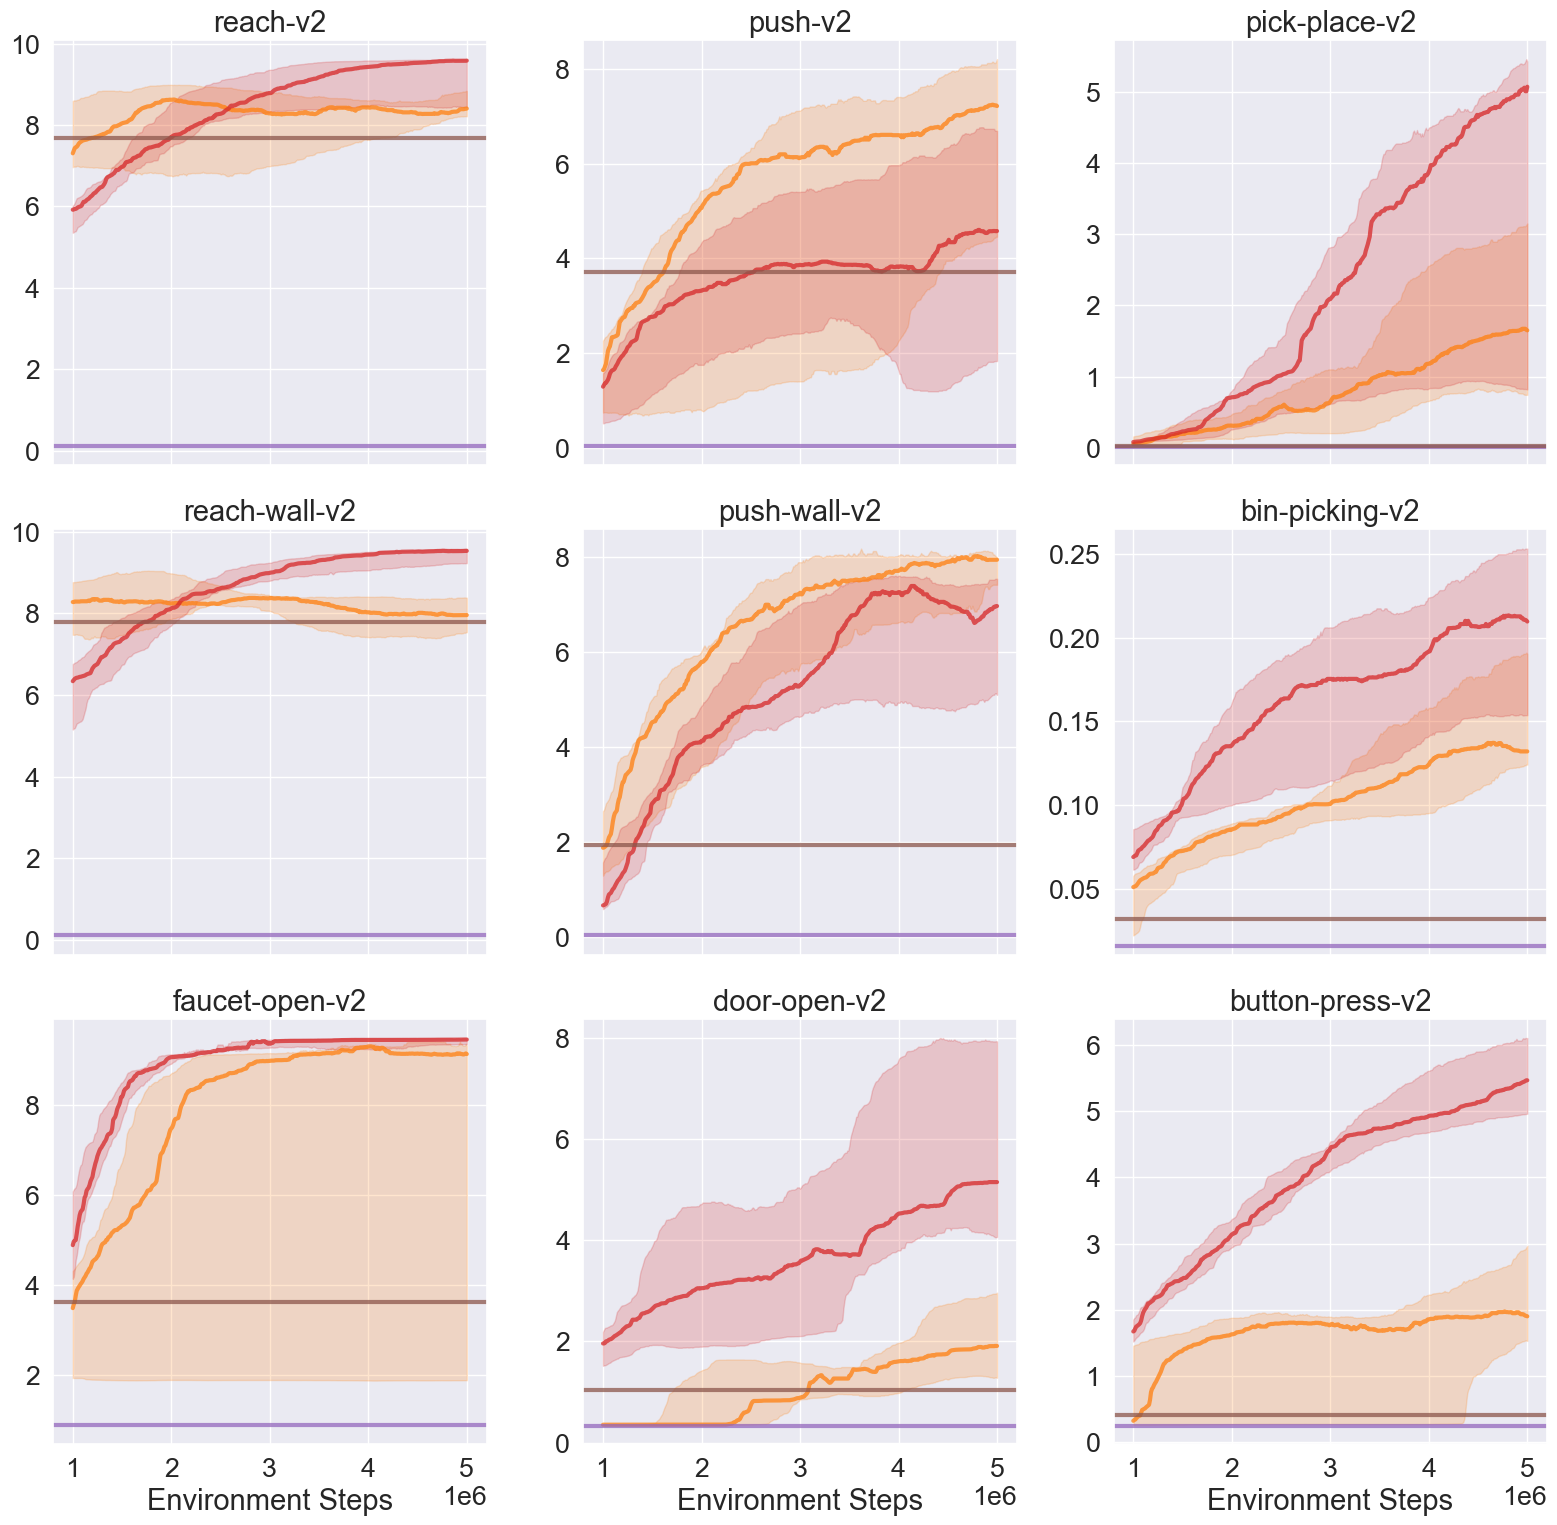

In [106]:
# to_remove = [
#     'right_only_double_params_train', 
#     'right_only_train', 
#     'random_train',
#     'right_only']

# plot_reward_trajectory(
#     df=train_data,#.query(f'~run_name.isin({TO_REMOVE})'),
#     to_remove = TO_REMOVE,
#     reward_col='rq_0.1',
#     window=WINDOW,
#     min_over=MIN_OVER,
#     tasks=TRAINING_TASKS,
#     figsize=(16,16),
#     ylabel='Lowest-decile rewards',
#     title=""#'Lowest Decile of Rewards by Task'
# )

plot_reward_trajectory(
    df=train_data,#.query(f'~run_name.isin({TO_REMOVE})'),
    to_remove = TO_REMOVE,
    reward_col='reward_mean',
    window=WINDOW,
    min_over=MIN_OVER,
    tasks=TRAINING_TASKS,
    figsize=(16,16),
    ylabel='Mean Rewards',
    title=''#'Mean Rewards by Task'
)

# plot_reward_trajectory(
#     df=train_data,#.query(f'~run_name.isin({TO_REMOVE})'),
#     to_remove = TO_REMOVE,
#     reward_col='num_successes',
#     window=WINDOW,
#     min_over=MIN_OVER,
#     tasks=TRAINING_TASKS,
#     figsize=(16,16),
#     ylabel='Success Rate',
#     title=''#'Success Rate by Task'
# )

In [331]:

def get_relative_reward(smoothed_df, reward_col, initial=True):
    if initial:
        frame = 1e6
    else:
        frame = 5e6
    left = (
        smoothed_df
        .query(f'frame=={frame}')
        .query('run_name=="left_only_double_params"')
        .rename(columns={reward_col:f'left_{reward_col}'})
        .drop(['frame', 'run_name'], axis=1)
    )
    bihem = (
        smoothed_df
        .query(f'frame=={frame}')
        .query('run_name=="bicameral_w_gating_encoder+penalty"')
    )

    combined = (
        pd.merge(
            bihem, left,
            on = ['training_task', 'seed']
        )
        .assign(
            relative_reward = lambda x: x[reward_col] / x[f"left_{reward_col}"]
        )
    )

    combined.index = pd.CategoricalIndex(
        combined.training_task,
        categories=TRAINING_TASKS)
    combined.sort_index(level=0, inplace=True)

    return combined

def plot_frr(test_data):
    test_smoothed_df = smooth_results_with_median(
        test_data,
        'reward_mean',
        window=10
    )
    combined = get_relative_reward(test_smoothed_df, 'reward_mean', initial=False)

    fig, ax = plt.subplots(figsize=(18,7))

    sns.violinplot(
        data=combined,
        x='training_task',
        y='relative_reward',
        hue='run_name',
        ax=ax,
        palette=PALETTE,
        # inner=None,
        density_norm='width',
        alpha=0.75, cut=0
    )

    relative_medians = (
            combined
            .drop('training_task', axis=1)
            .reset_index()
            .groupby(['training_task', 'run_name'])
            .median()
            .assign(gt_1=lambda x: 1*(x.relative_reward>=1))
            # .reset_index()
        )

    sns.swarmplot(
        data = relative_medians,
        x='training_task',
        y='relative_reward',
        hue='gt_1',
        palette={1: 'blue', 0:'red'},
        alpha = 0.6,
        linewidth=1,
        size=15

    )

    for txt in relative_medians.reset_index().itertuples():
        ax.text(txt.training_task, txt.relative_reward+0.05, np.round(txt.relative_reward, 2))

    ax.axhline(1, c='black', alpha = 0.7)
    ax.set_ylabel("FRR")
    ax.set_xlabel(None)
    ax.get_legend().remove()


    plt.tight_layout()
    plt.show();

def plot_irr(train_data):
    smoothed_df = smooth_results_with_median(
        train_data,
        'reward_mean',
        window=100
    )
    combined = get_relative_reward(smoothed_df, 'reward_mean', initial=True)

    fig, ax = plt.subplots(figsize=(18,7))

    sns.violinplot(
        data=combined,
        x='training_task',
        y='relative_reward',
        hue='run_name',
        ax=ax,
        palette=PALETTE,
        # inner=None,
        density_norm='width',
        alpha=0.75, cut=0
    )

    relative_medians = (
            combined
            .drop('training_task', axis=1)
            .reset_index()
            .groupby(['training_task', 'run_name'])
            .median()
            .assign(gt_1=lambda x: 1*(x.relative_reward>=1))
            # .reset_index()
        )

    sns.swarmplot(
        data = relative_medians,
        x='training_task',
        y='relative_reward',
        hue='gt_1',
        palette={1: 'blue', 0:'red'},
        alpha = 0.6,
        linewidth=1,
        size=15

    )

    for txt in relative_medians.reset_index().itertuples():
        ax.text(txt.training_task, txt.relative_reward+0.05, np.round(txt.relative_reward, 2))

    ax.axhline(1, c='black', alpha = 0.7)
    ax.set_ylabel("IRR")
    ax.set_xlabel(None)
    ax.get_legend().remove()


    plt.tight_layout()
    plt.show();

def plot_left_only_vs_relative(
    train_data, test_data, relative_reward_col, left_only_reward_col, 
    initial, xlabel, ylabel, figsize=(14,7)
    ):
    
    test_smoothed_df = smooth_results_with_median(
        test_data,
        'reward_mean',
        window=10
    )
    frr_data = (
        get_relative_reward(test_smoothed_df, 'reward_mean', initial=False)
        .drop('training_task', axis=1)
        .reset_index()
        .loc[:, ['training_task', 'run_name', 'seed', 'relative_reward']]
        .rename(columns={
            'relative_reward':'FRR'
        })
    )

    smoothed_df = smooth_results_with_median(
        train_data,
        'reward_mean',
        window=100
    )
    irr_data = (
        get_relative_reward(smoothed_df, 'reward_mean', initial=True)
        .drop('training_task', axis=1)
        .reset_index()
        .loc[:, ['training_task', 'run_name', 'seed', 'relative_reward']]
        .rename(columns={
            'relative_reward':'IRR'
        })
    )

    fig, ax = plt.subplots(1,1,figsize=figsize, sharex=True, sharey=True)
    # ax = ax.flatten()
    irr_vs_frr = (
        pd.merge(
            irr_data,
            frr_data,
            on = ['training_task', 'run_name', 'seed']
        )
        .groupby(['training_task', 'run_name'])
        .median()
        .reset_index()
    )
    for i, alg in enumerate(np.unique(irr_vs_frr.run_name)):
        sns.scatterplot(
            data=irr_vs_frr.query(f'run_name=="{alg}"'),
            x='FRR',
            y = 'IRR',
            hue='training_task',
            palette=TASK_PALETTE,
            s=350,
            alpha=0.75,
            ax = ax
        )
        ax.set(title=LABEL_MAPPING[alg], xlabel=xlabel, ylabel=ylabel)
        ax.axhline(1, c='black')
        ax.axvline(1, c='black')
        ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

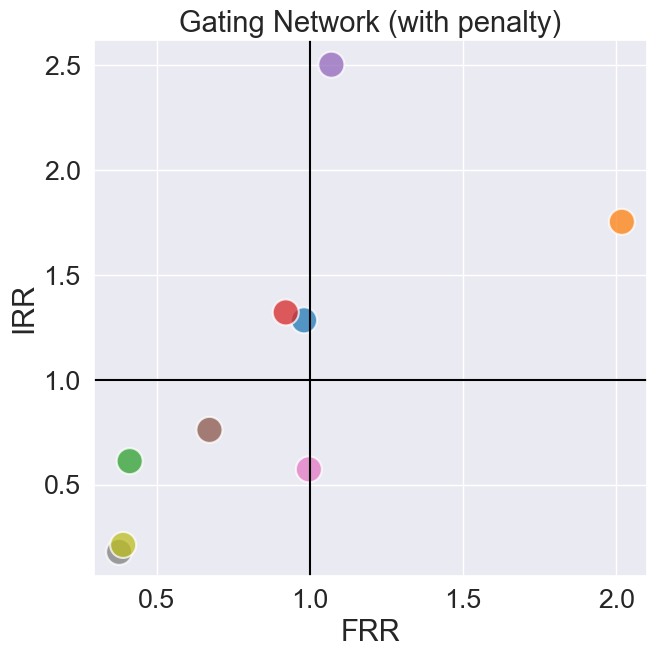

In [332]:
## reward mean
plot_left_only_vs_relative(
    train_data = train_data, 
    # left_eval_data=left_eval_data, 
    test_data=test_data, 
    relative_reward_col='reward_mean', 
    left_only_reward_col='reward_mean', 
    initial=True, 
    xlabel="FRR", 
    ylabel="IRR", 
    figsize=(7,7)
    )



In [224]:
## should make an FRR function
def get_relative_reward(smoothed_df, reward_col, initial=True):
    if initial:
        frame = 1e6
    else:
        frame = 5e6
    left = (
        smoothed_df
        .query(f'frame=={frame}')
        .query('run_name=="left_only_double_params"')
        .rename(columns={reward_col:f'left_{reward_col}'})
        .drop(['frame', 'run_name'], axis=1)
    )
    bihem = (
        smoothed_df
        .query(f'frame=={frame}')
        .query('run_name=="bicameral_w_gating_encoder+penalty"')
    )

    combined = (
        pd.merge(
            bihem, left,
            on = ['training_task', 'seed']
        )
        .assign(
            relative_reward = lambda x: x[reward_col] / x[f"left_{reward_col}"]
        )
    )

    combined.index = pd.CategoricalIndex(
        combined.training_task,
        categories=TRAINING_TASKS)
    combined.sort_index(level=0, inplace=True)

    return combined

In [299]:
def get_relative_reward(smoothed_df, reward_col, initial=True):
    if initial:
        frame = 1e6
    else:
        frame = 5e6
    left = (
        smoothed_df
        .query(f'frame=={frame}')
        .query('run_name=="left_only_double_params"')
        .rename(columns={reward_col:f'left_{reward_col}'})
        .drop(['frame', 'run_name'], axis=1)
    )
    bihem = (
        smoothed_df
        .query(f'frame=={frame}')
        .query('run_name=="bicameral_w_gating_encoder+penalty"')
    )

    combined = (
        pd.merge(
            bihem, left,
            on = ['training_task', 'seed']
        )
        .assign(
            relative_reward = lambda x: x[reward_col] / x[f"left_{reward_col}"]
        )
    )

    combined.index = pd.CategoricalIndex(
        combined.training_task,
        categories=TRAINING_TASKS)
    combined.sort_index(level=0, inplace=True)

    return combined

def plot_frr(test_data):
    test_smoothed_df = smooth_results_with_median(
        test_data,
        'reward_mean',
        window=10
    )
    combined = get_relative_reward(test_smoothed_df, 'reward_mean', initial=False)

    fig, ax = plt.subplots(figsize=(18,7))

    sns.violinplot(
        data=combined,
        x='training_task',
        y='relative_reward',
        hue='run_name',
        ax=ax,
        palette=PALETTE,
        # inner=None,
        density_norm='width',
        alpha=0.75, cut=0
    )

    relative_medians = (
            combined
            .drop('training_task', axis=1)
            .reset_index()
            .groupby(['training_task', 'run_name'])
            .median()
            .assign(gt_1=lambda x: 1*(x.relative_reward>=1))
            # .reset_index()
        )

    sns.swarmplot(
        data = relative_medians,
        x='training_task',
        y='relative_reward',
        hue='gt_1',
        palette={1: 'blue', 0:'red'},
        alpha = 0.6,
        linewidth=1,
        size=15

    )

    for txt in relative_medians.reset_index().itertuples():
        ax.text(txt.training_task, txt.relative_reward+0.05, np.round(txt.relative_reward, 2))

    ax.axhline(1, c='black', alpha = 0.7)
    ax.set_ylabel("FRR")
    ax.set_xlabel(None)
    ax.get_legend().remove()


    plt.tight_layout()
    plt.show();

def plot_irr(train_data):
    smoothed_df = smooth_results_with_median(
        train_data,
        'reward_mean',
        window=100
    )
    combined = get_relative_reward(smoothed_df, 'reward_mean', initial=True)

    fig, ax = plt.subplots(figsize=(18,7))

    sns.violinplot(
        data=combined,
        x='training_task',
        y='relative_reward',
        hue='run_name',
        ax=ax,
        palette=PALETTE,
        # inner=None,
        density_norm='width',
        alpha=0.75, cut=0
    )

    relative_medians = (
            combined
            .drop('training_task', axis=1)
            .reset_index()
            .groupby(['training_task', 'run_name'])
            .median()
            .assign(gt_1=lambda x: 1*(x.relative_reward>=1))
            # .reset_index()
        )

    sns.swarmplot(
        data = relative_medians,
        x='training_task',
        y='relative_reward',
        hue='gt_1',
        palette={1: 'blue', 0:'red'},
        alpha = 0.6,
        linewidth=1,
        size=15

    )

    for txt in relative_medians.reset_index().itertuples():
        ax.text(txt.training_task, txt.relative_reward+0.05, np.round(txt.relative_reward, 2))

    ax.axhline(1, c='black', alpha = 0.7)
    ax.set_ylabel("IRR")
    ax.set_xlabel(None)
    ax.get_legend().remove()


    plt.tight_layout()
    plt.show();

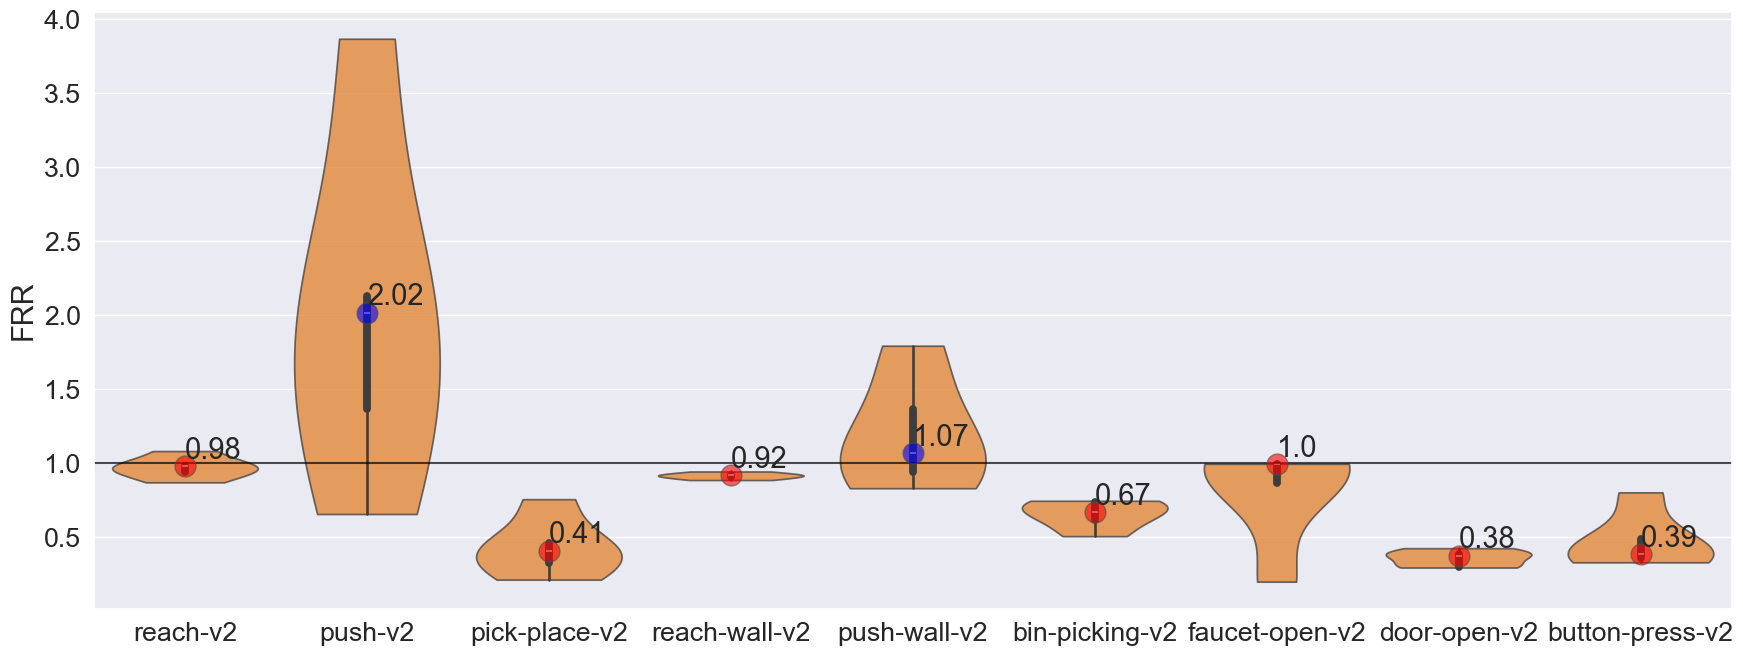

In [300]:
plot_frr(test_data)

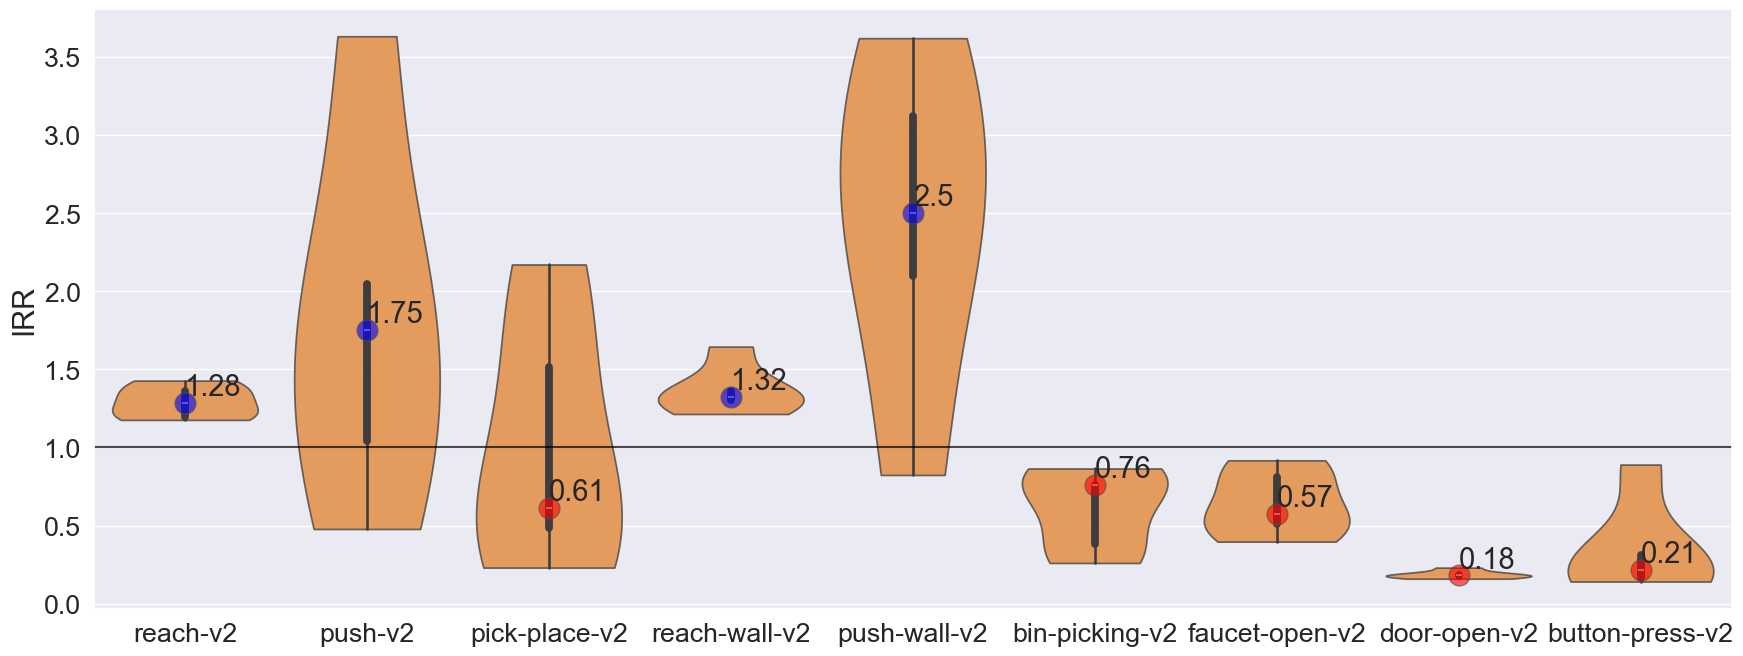

In [301]:
plot_irr(train_data)

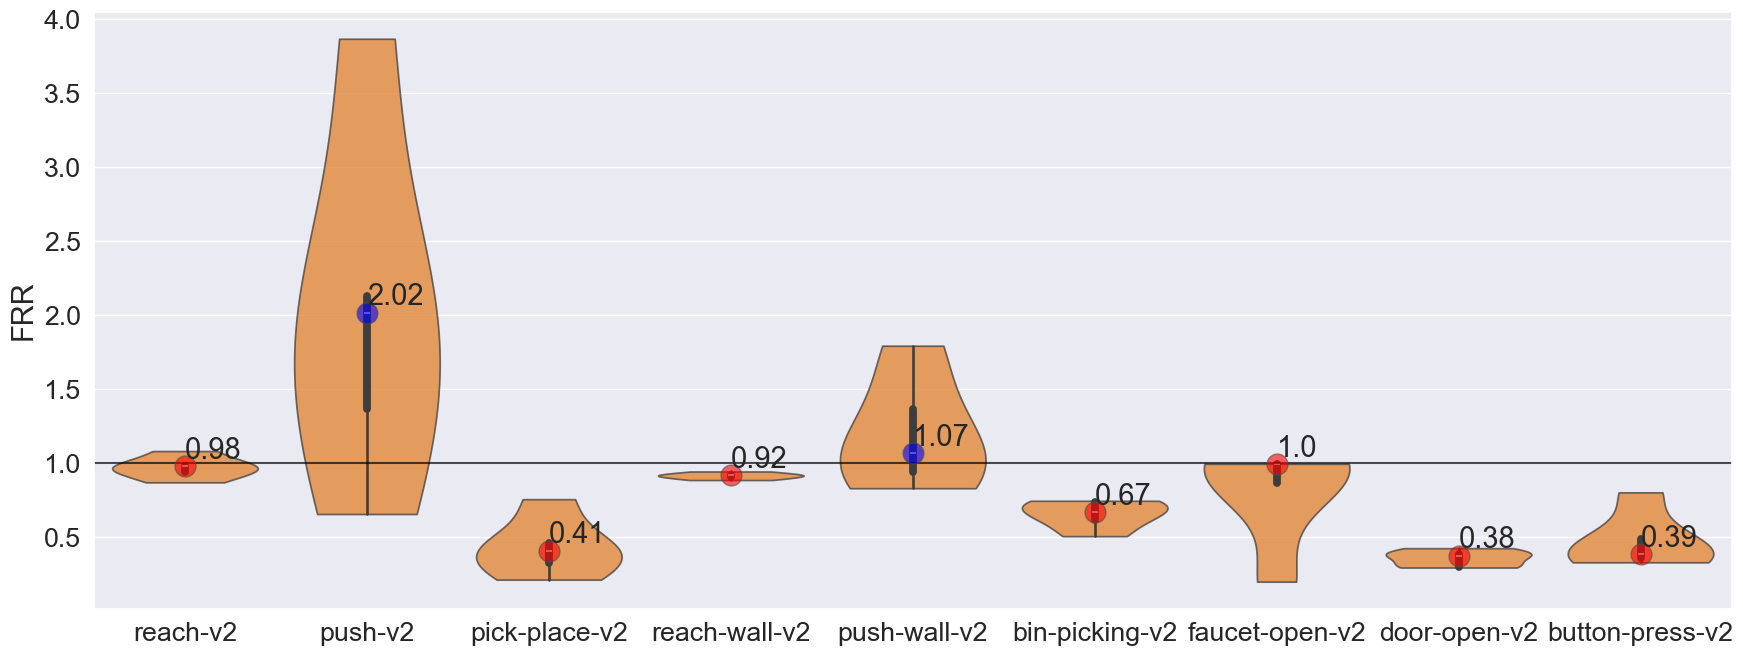

In [286]:
test_smoothed_df = smooth_results_with_median(
    test_data,
    'reward_mean',
    window=10
)
combined = get_relative_reward(test_smoothed_df, 'reward_mean', initial=False)

fig, ax = plt.subplots(figsize=(18,7))

sns.violinplot(
    data=combined,
    x='training_task',
    y='relative_reward',
    hue='run_name',
    ax=ax,
    palette=PALETTE,
    # inner=None,
    density_norm='width',
    alpha=0.75, cut=0
)

relative_medians = (
        combined
        .drop('training_task', axis=1)
        .reset_index()
        .groupby(['training_task', 'run_name'])
        .median()
        .assign(gt_1=lambda x: 1*(x.relative_reward>=1))
        # .reset_index()
    )

sns.swarmplot(
    data = relative_medians,
    x='training_task',
    y='relative_reward',
    hue='gt_1',
    palette={1: 'blue', 0:'red'},
    alpha = 0.6,
    linewidth=1,
    size=15

)

for txt in relative_medians.reset_index().itertuples():
    ax.text(txt.training_task, txt.relative_reward+0.05, np.round(txt.relative_reward, 2))

ax.axhline(1, c='black', alpha = 0.7)
ax.set_ylabel("FRR")
ax.set_xlabel(None)
ax.get_legend().remove()


plt.tight_layout()
plt.show();

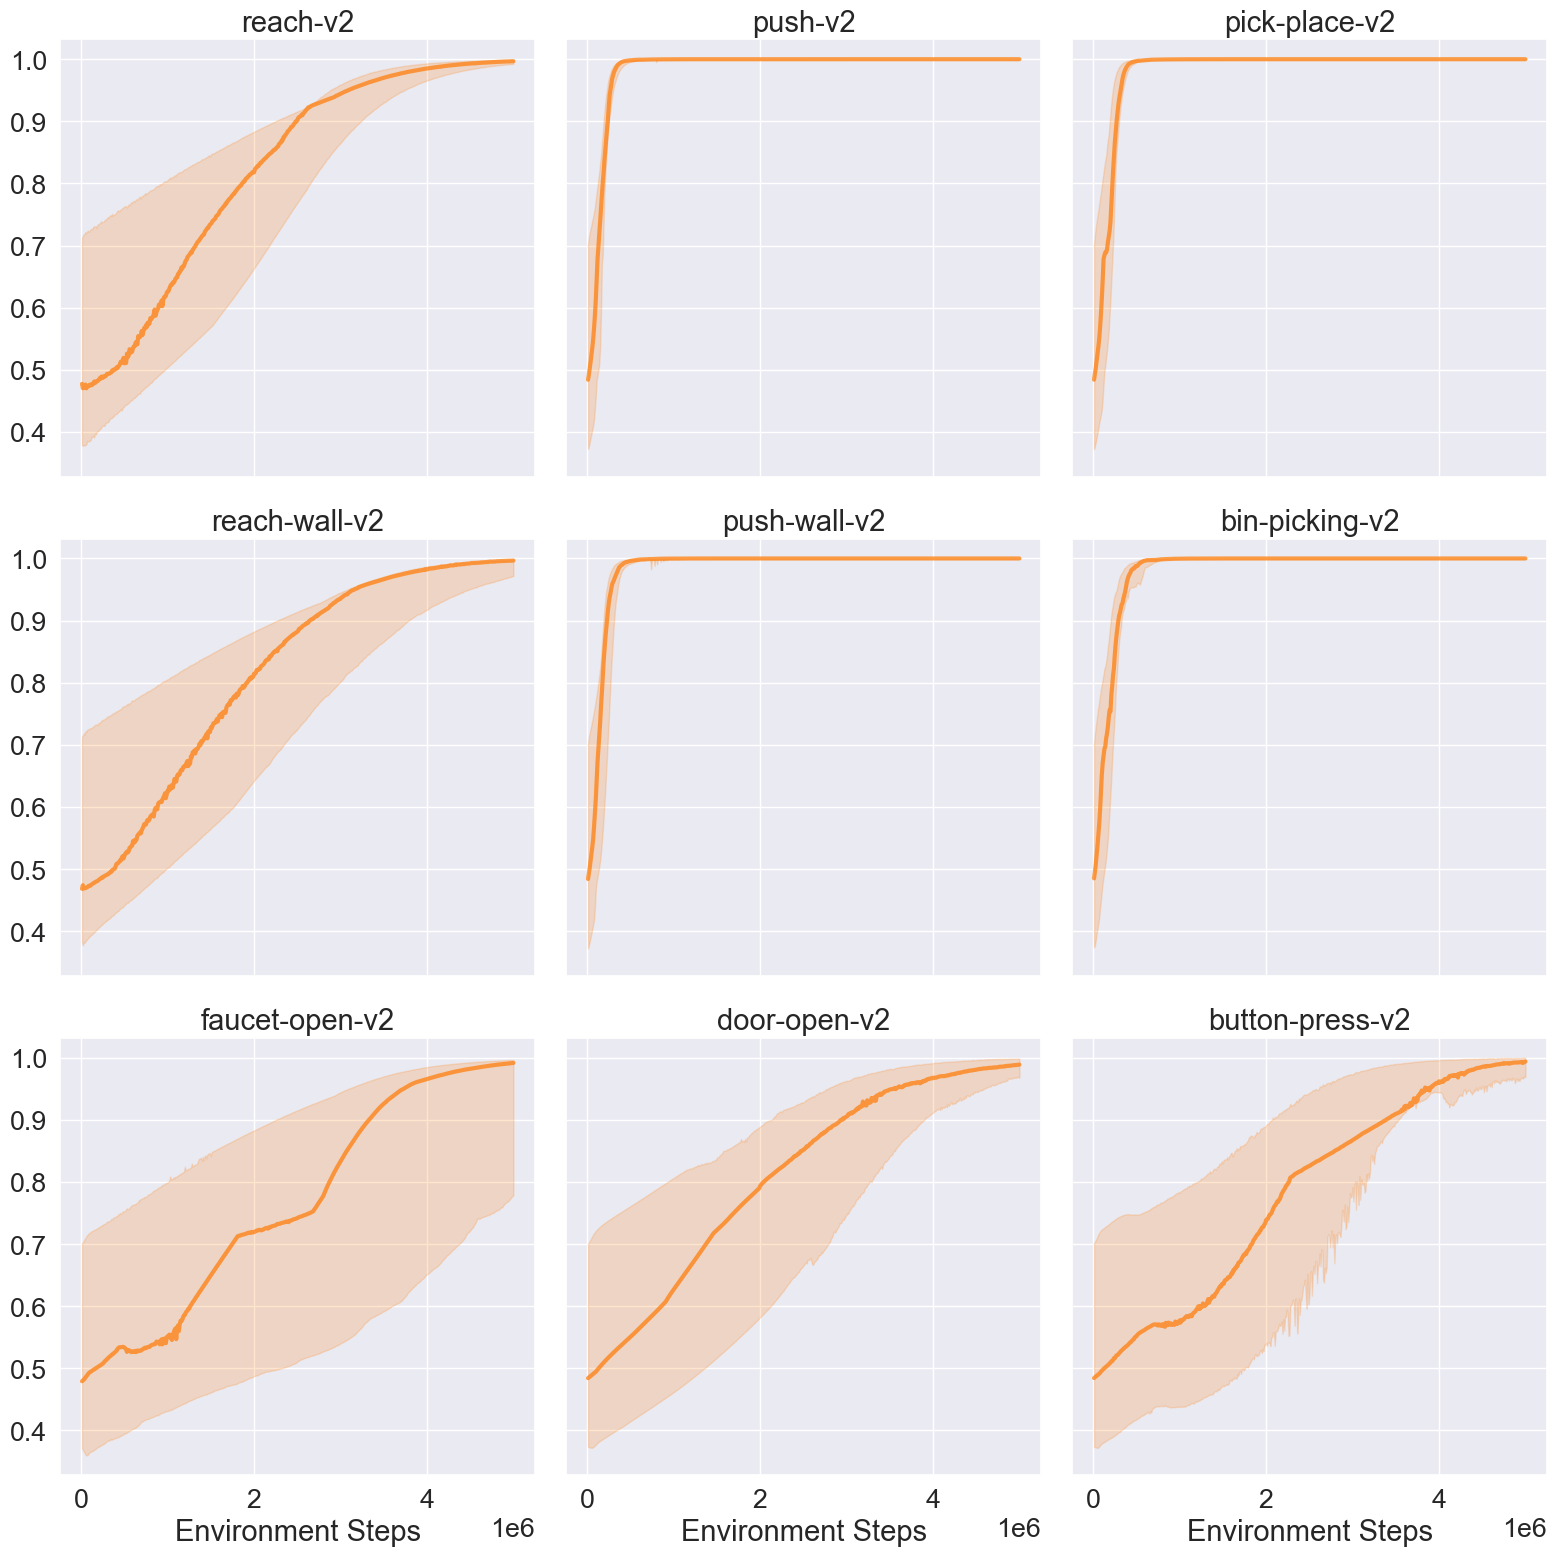

In [158]:
to_remove_gate = TO_REMOVE + ['left_only_double_params', 'right_only_double_params']

to_plot = (
    train_data
    .query(f'~run_name.isin({to_remove_gate})')
)

fig, ax = plt.subplots(3,3,figsize=(16,16), sharex = True, sharey=True)
ax = ax.flatten()

for i, task in enumerate(TRAINING_TASKS):

    sns.lineplot(
        data = to_plot.query(f'training_task=="{task}"'),
        x='frame',
        y='gq_0.5',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE,
        alpha = 0.75,
        linewidth=3,
        estimator='median',
        errorbar=lambda x: (x.min(), x.max())
    )

    ax[i].get_legend().remove()
        
    ax[i].set_title(task)
    ax[i].set(ylabel='', xlabel='Environment Steps')

plt.tight_layout()
plt.show();

In [18]:
def get_left_median(df, reward_col, min_over=1e6):
    return (
        df
        .loc[:, ['frame', 'training_task', 'run_name', reward_col]]
        .query('run_name=="left_only_double_params"')
        .query(f'frame<={min_over}')
        .groupby(['training_task', 'run_name'])
        .median()
        .reset_index()
        .drop(['run_name', 'frame'], axis=1)
        .rename(columns={reward_col:f"left_{reward_col}"})
    )

def get_left_min(df, reward_col):
    return (
        df
        .loc[:, ['frame', 'training_task', 'run_name', reward_col]]
        .query('run_name=="left_only_double_params"')
        .groupby(['training_task', 'run_name'])
        .min()
        .reset_index()
        .drop(['run_name', 'frame'], axis=1)
        .rename(columns={reward_col:f"left_{reward_col}"})
    )

def compare_to_left_min(df, left_min, reward_col):
    return (
        df
        .merge(
            left_min,
            on = 'training_task'
        )
        .assign(**{reward_col:lambda x: x[reward_col]/x[f"left_{reward_col}"]})
        .dropna()
    )

def get_median_vs_left_min(df, reward_col, window, min_over, use_left_min = False, use_left_median=False):

    ## smoothes results using rolling median
    smoothed_df = smooth_results_with_median(
        df=df,
        reward_col=reward_col,
        window=window
    )
    ## gets left aggregation
    if use_left_min and not use_left_median:

        ## minimum value achieved by left
        left_min = get_left_min(
            df=smoothed_df,
            reward_col=reward_col
        )
        return compare_to_left_min(df=smoothed_df, left_min=left_min, reward_col=reward_col)
    elif use_left_median and not use_left_min:

        ## median value achieved by left
        left_min = get_left_median(
            df=smoothed_df,
            reward_col=reward_col,
            min_over=min_over
        )
        return compare_to_left_min(df=smoothed_df, left_min=left_min, reward_col=reward_col)
    elif use_left_median and use_left_min:
        raise ValueError("At least one of use_left_min and use_left_median must be false")
    else:
        return smoothed_df

,training_task,run_name,frame,reward_mean
0,bin-picking-v2,bicameral_w_gating_encoder+penalty,10000,NaN
1,bin-picking-v2,bicameral_w_gating_encoder+penalty,20000,NaN
2,bin-picking-v2,bicameral_w_gating_encoder+penalty,30000,NaN
3,bin-picking-v2,bicameral_w_gating_encoder+penalty,40000,NaN
4,bin-picking-v2,bicameral_w_gating_encoder+penalty,50000,NaN
...,...,...,...,...
48145,reach-wall-v2,right_only_double_params,960000,NaN
48146,reach-wall-v2,right_only_double_params,970000,NaN
48147,reach-wall-v2,right_only_double_params,980000,NaN
48148,reach-wall-v2,right_only_double_params,990000,NaN
